In [41]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud

# Downloads NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Carregando o dataset
df = pd.read_excel('BBC.xlsx')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Henri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Henri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [42]:
# Pré-processamento de texto
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
blacklist = ['said']

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words and word not in blacklist]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# Função para treinar e avaliar o modelo com matrizes de confusão
def train_and_evaluate(model, X_train_bow, X_test_bow, y_train, y_test, num_iterations=10):
    train_accuracies, test_accuracies = [], []
    conf_matrices = np.zeros((len(df['category'].unique()), len(df['category'].unique())))

    for _ in range(num_iterations):
        # Divisão de treino e teste
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_bow, y_train, test_size=0.2, stratify=y_train)
        
        # Treinamento
        model.fit(X_train_split, y_train_split)
        
        # Cálculo das acurácias
        y_train_pred = model.predict(X_train_split)
        y_test_pred = model.predict(X_test_split)
        train_accuracies.append(accuracy_score(y_train_split, y_train_pred))
        test_accuracies.append(accuracy_score(y_test_split, y_test_pred))

        # Acumulação das matrizes de confusão
        conf_matrices += confusion_matrix(y_test_split, y_test_pred)

    # Resultados médios
    mean_train_accuracy = np.mean(train_accuracies)
    mean_test_accuracy = np.mean(test_accuracies)

    # Exibição das matrizes e relatórios
    print(f'Mean Training Accuracy: {mean_train_accuracy:.4f}')
    print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrices / num_iterations, annot=True, fmt='.2f', cmap='Blues', xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Vetorização Bag-of-Words
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['clean_text'])

# Dividindo os dados para treino e teste
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['category'], test_size=0.2, stratify=df['category'], random_state=42)

# Definindo os modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB()
}

In [43]:
# Análise de Tópicos com LDA, removendo a palavra "said" da análise
lda = LatentDirichletAllocation(n_components=5, random_state=42)
X_topics = lda.fit_transform(X_train_bow)
topic_words = vectorizer.get_feature_names_out()

# Definindo uma blacklist de palavras a serem ignoradas nos tópicos
blacklist = ['said']

# Nomeando os tópicos manualmente para que tenham mais significado
topic_names = ['Sports', 'Technology', 'Business', 'Entertainment', 'Politics']

# Palavras principais de cada tópico, ignorando as que estão na blacklist
for i, topic in enumerate(lda.components_):
    top_words = [topic_words[j] for j in topic.argsort()[-20:] if topic_words[j] not in blacklist]
    print(f"\nTop 10 words for {topic_names[i]} Topic:")
    print(top_words[-10:])


Top 10 words for Sports Topic:
['blair', 'minister', 'say', 'people', 'election', 'party', 'labour', 'government', 'would', 'mr']

Top 10 words for Technology Topic:
['new', 'service', 'also', 'one', 'technology', 'year', 'phone', 'mobile', 'game', 'people']

Top 10 words for Business Topic:
['song', 'company', 'one', 'would', 'site', 'software', 'firm', 'people', 'new', 'music']

Top 10 words for Entertainment Topic:
['last', 'win', 'first', 'star', 'also', 'world', 'award', 'year', 'best', 'film']

Top 10 words for Politics Topic:
['bank', 'sale', 'firm', 'also', 'would', 'market', 'last', 'mr', 'company', 'year']



Logistic Regression Model:
Mean Training Accuracy: 1.0000
Mean Test Accuracy: 0.9649


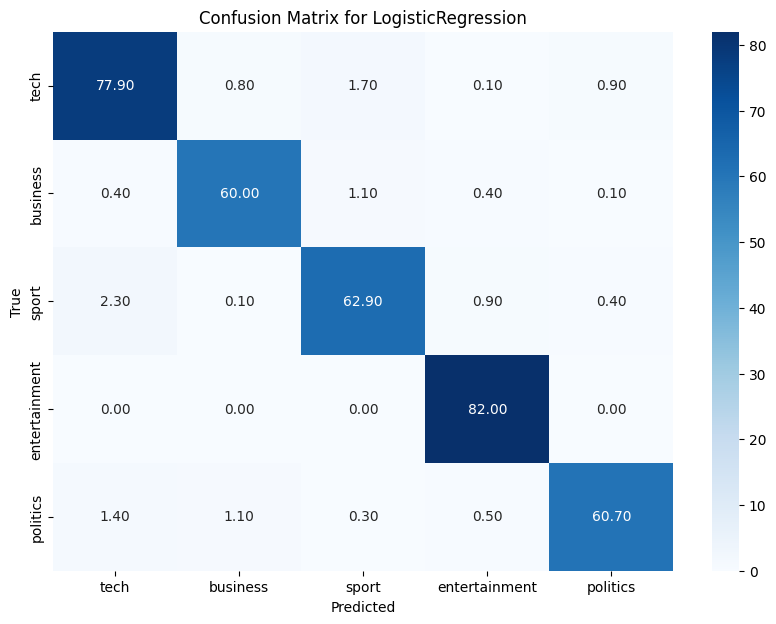


Naive Bayes Model:
Mean Training Accuracy: 0.9941
Mean Test Accuracy: 0.9683


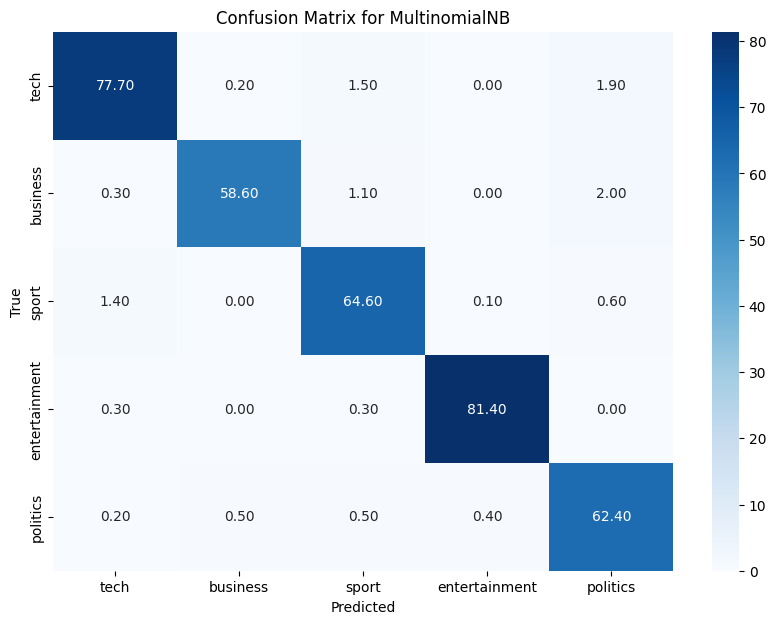

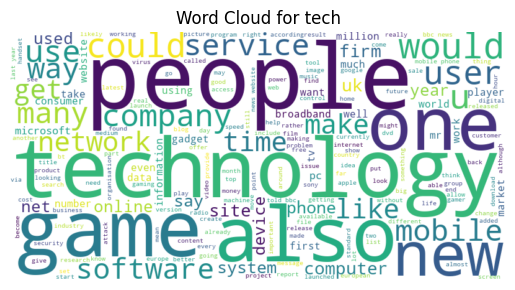

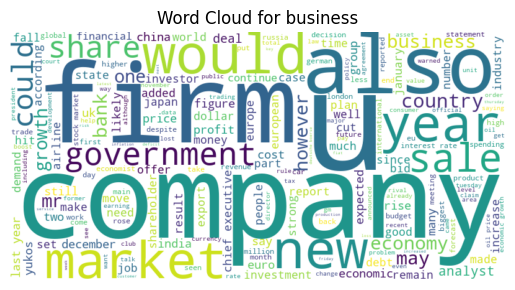

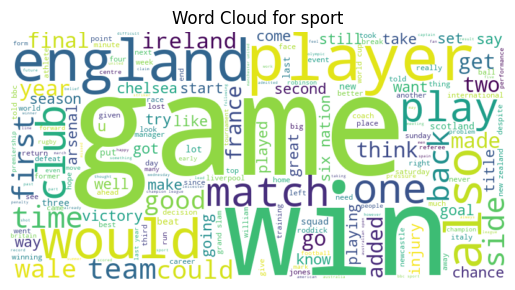

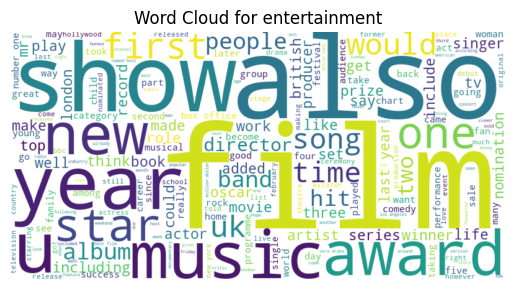

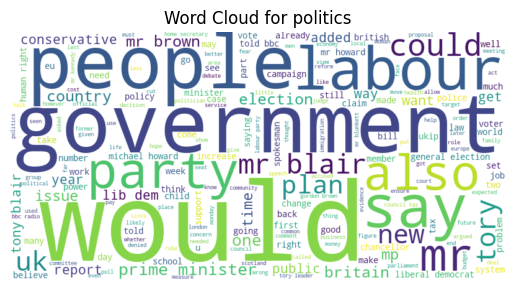

In [44]:
# Avaliando os modelos
for name, model in models.items():
    print(f"\n{name} Model:")
    train_and_evaluate(model, X_train_bow, X_test_bow, y_train, y_test, num_iterations=10)

# Análise de Nuvem de Palavras
for category in df['category'].unique():
    text = ' '.join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=blacklist).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

In [45]:
# Avaliação de desempenho com downsampling do dataset
sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
train_errors, test_errors = [], []

for size in sample_sizes:
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train_bow, y_train, train_size=size, stratify=y_train)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_sample, y_train_sample)
    train_errors.append(1 - model.score(X_train_sample, y_train_sample))
    test_errors.append(1 - model.score(X_test_bow, y_test))


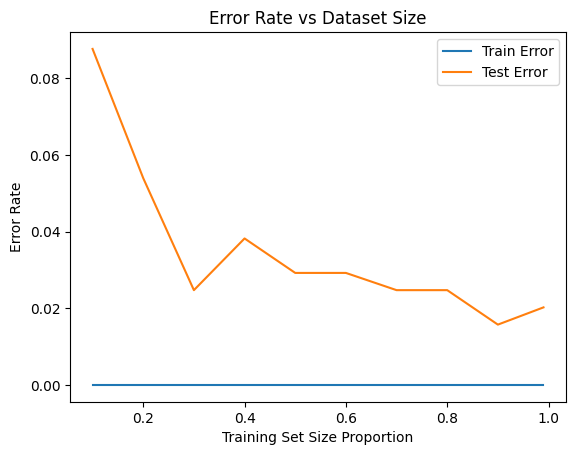

In [46]:
plt.figure()
plt.plot(sample_sizes, train_errors, label='Train Error')
plt.plot(sample_sizes, test_errors, label='Test Error')
plt.xlabel('Training Set Size Proportion')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Dataset Size')
plt.legend()
plt.show()